In [1]:
#IPython extension to reload modules before executing user code.
#'autoreload' reloads modules automatically before entering the execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['PYTHONHASHSEED'] = '0'
import gpustat

#select the best free GPU
stats = gpustat.GPUStatCollection.new_query()
ids = map(lambda gpu: int(gpu.entry['index']), stats)
ratios = map(lambda gpu: float(gpu.entry['memory.used'])/float(gpu.entry['memory.total']), stats)
bestGPU = min(zip(ids, ratios), key=lambda x: x[1])[0]
bestGPU = 0

print("setGPU: Setting GPU to: {}".format(bestGPU))
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = str(bestGPU)

'''
#set memory usage to 0.5
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))'''

setGPU: Setting GPU to: 0


'\n#set memory usage to 0.5\nfrom keras.backend.tensorflow_backend import set_session\nimport tensorflow as tf\nconfig = tf.ConfigProto()\nconfig.gpu_options.per_process_gpu_memory_fraction = 0.5\nset_session(tf.Session(config=config))'

In [3]:
#!pip install -q keract 
import collections
import numpy
from keract import get_activations
import keras
from keras import backend as K
from keras import optimizers, regularizers
from keras.callbacks import LearningRateScheduler
from keras.datasets import cifar10 # we can use also cifar100
from keras.layers import Input, BatchNormalization, AveragePooling2D, ZeroPadding2D, LeakyReLU, GlobalAveragePooling2D, Dense, Flatten, Activation, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential, load_model, Model
from keras.regularizers import l2
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
import scipy
import sklearn
import sklearn.metrics
import time
from IPython.display import SVG

Using TensorFlow backend.


In [4]:
import sys
sys.path.insert(0, "../")
from models import VGG16, VGG16_Vanilla, VGG16_beta,VGG16_Vanilla_beta
from data_utils import import_cifar

In [5]:
# LOAD DATA
num_classes = 10
# The data, split between train and test sets:
'''(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255'''

(x_train, y_train), (x_test, y_test) = import_cifar(10)

### Loading models

In [6]:
# LOAD huge MODELS
modelA = VGG16_Vanilla_beta(input_shape=(32,32,3), num_classes=10) #with less generalization
modelB = VGG16_beta(input_shape=(32,32,3), num_classes=10, weight_decay=0.005) #with more generalization
modelC = VGG16_Vanilla_beta(input_shape=(32,32,3), num_classes=10) #with less generalization, and layca


# Initial and final weights
W_i = collections.defaultdict(list)
W_f = collections.defaultdict(list)

modelA.load_weights("../weights/final/vgg16_vanilla_beta.h5")
modelB.load_weights("../weights/final/vgg16_beta.h5")
modelC.load_weights("../weights/final/vgg16_vanilla_beta_layca.h5")

sgd = optimizers.SGD(lr=0.2, momentum=0.9, nesterov=True)
modelA.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
modelB.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
modelC.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])


In [7]:
# EVALUATION
# Final evaluation of the models
scoresA = modelA.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scoresA[0])
print('Test accuracy:', scoresA[1])
print("Model A without Weightdecay CNN Error: %.2f%%" % (100-scoresA[1]*100))
scoresB = modelB.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scoresB[0])
print('Test accuracy:', scoresB[1])
print("Model B with Weightdecay CNN Error: %.2f%%" % (100-scoresB[1]*100))
scoresC = modelC.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scoresC[0])
print('Test accuracy:', scoresC[1])
print("Model C without Weightdecay with layca CNN Error: %.2f%%" % (100-scoresC[1]*100))

10000/10000 [==============================] - 4s 426us/step
Test loss: 0.7984343766212464
Test accuracy: 0.82
Model A without Weightdecay CNN Error: 18.00%
10000/10000 [==============================] - 3s 320us/step
Test loss: 0.6959439407348633
Test accuracy: 0.8713
Model B with Weightdecay CNN Error: 12.87%
10000/10000 [==============================] - 3s 284us/step
Test loss: 0.747343320941925
Test accuracy: 0.8422
Model C without Weightdecay with layca CNN Error: 15.78%


### Mutual Information
On regarde l'information mutuelle arrondie à des binaires.

In [8]:
# On regarde l'activation des neurones pour un echantillon test
Echantillon = []
nombreDImagesDActivation = 150
NombrePairs = 10000
choix = numpy.random.choice(x_test.shape[0], nombreDImagesDActivation)
Echantillon = x_test[choix, :, : , :]

#Echantillon = [x_test[0], x_test[1], x_test[2], x_test[3], x_test[4], x_test[5], x_test[6], x_test[7], x_test[8], x_test[9], x_test[10], x_test[11], x_test[12], x_test[13]]
IMA = get_activations(modelA, Echantillon)
IMB = get_activations(modelB, Echantillon)
IMC = get_activations(modelC, Echantillon)

In [9]:
# on affiche les noms des differentes couches
print(IMA.keys())
print('\n')
print(IMB.keys())
print('\n')
print(IMC.keys())

dict_keys(['activation_3/Relu:0', 'conv2d_10/BiasAdd:0', 'activation_10/Relu:0', 'conv2d_3/BiasAdd:0', 'activation_1/Relu:0', 'batch_normalization_10/cond/Merge:0', 'max_pooling2d_5/MaxPool:0', 'batch_normalization_2/cond/Merge:0', 'conv2d_12/BiasAdd:0', 'batch_normalization_7/cond/Merge:0', 'batch_normalization_13/cond/Merge:0', 'batch_normalization_12/cond/Merge:0', 'conv2d_11/BiasAdd:0', 'batch_normalization_8/cond/Merge:0', 'activation_7/Relu:0', 'batch_normalization_14/cond/Merge:0', 'conv2d_6/BiasAdd:0', 'activation_5/Relu:0', 'conv2d_9/BiasAdd:0', 'max_pooling2d_4/MaxPool:0', 'activation_13/Relu:0', 'activation_4/Relu:0', 'activation_12/Relu:0', 'conv2d_5/BiasAdd:0', 'batch_normalization_5/cond/Merge:0', 'dense_2/BiasAdd:0', 'activation_11/Relu:0', 'conv2d_2/BiasAdd:0', 'activation_6/Relu:0', 'max_pooling2d_1/MaxPool:0', 'flatten_1/Reshape:0', 'conv2d_8/BiasAdd:0', 'batch_normalization_15/cond/Merge:0', 'dense_1/BiasAdd:0', 'activation_14/Relu:0', 'max_pooling2d_2/MaxPool:0', 'c

In [10]:
modelA.summary()
modelB.summary()
modelC.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
__________

In [11]:
List_of_Layers_A = [
'conv2d_1/BiasAdd:0', 
'conv2d_2/BiasAdd:0',
'max_pooling2d_1/MaxPool:0',
'conv2d_3/BiasAdd:0', 
'conv2d_4/BiasAdd:0', 
'max_pooling2d_2/MaxPool:0',
'conv2d_5/BiasAdd:0', 
'conv2d_6/BiasAdd:0',  
'conv2d_7/BiasAdd:0', 
'max_pooling2d_3/MaxPool:0', 
'conv2d_8/BiasAdd:0',  
'conv2d_9/BiasAdd:0', 
'conv2d_10/BiasAdd:0', 
'max_pooling2d_4/MaxPool:0', 
'conv2d_11/BiasAdd:0',    
'conv2d_12/BiasAdd:0',
'conv2d_13/BiasAdd:0', 
'max_pooling2d_5/MaxPool:0', 
'dense_1/BiasAdd:0', 
'dense_2/BiasAdd:0', 
 ]

List_of_Layers_B = [
'conv2d_14/BiasAdd:0', 
'conv2d_15/BiasAdd:0',
'max_pooling2d_6/MaxPool:0',
'conv2d_16/BiasAdd:0', 
'conv2d_17/BiasAdd:0', 
'max_pooling2d_7/MaxPool:0',
'conv2d_18/BiasAdd:0', 
'conv2d_19/BiasAdd:0',  
'conv2d_20/BiasAdd:0', 
'max_pooling2d_8/MaxPool:0', 
'conv2d_21/BiasAdd:0',  
'conv2d_22/BiasAdd:0', 
'conv2d_23/BiasAdd:0', 
'max_pooling2d_9/MaxPool:0', 
'conv2d_24/BiasAdd:0',    
'conv2d_25/BiasAdd:0',
'conv2d_26/BiasAdd:0', 
'max_pooling2d_10/MaxPool:0', 
'dense_3/BiasAdd:0', 
'dense_4/BiasAdd:0', 
 ]

List_of_Layers_C = [
'conv2d_27/BiasAdd:0', 
'conv2d_28/BiasAdd:0',
'max_pooling2d_11/MaxPool:0',
'conv2d_29/BiasAdd:0', 
'conv2d_30/BiasAdd:0', 
'max_pooling2d_12/MaxPool:0',
'conv2d_31/BiasAdd:0', 
'conv2d_32/BiasAdd:0',  
'conv2d_33/BiasAdd:0', 
'max_pooling2d_13/MaxPool:0', 
'conv2d_34/BiasAdd:0',  
'conv2d_35/BiasAdd:0', 
'conv2d_36/BiasAdd:0', 
'max_pooling2d_14/MaxPool:0', 
'conv2d_37/BiasAdd:0',    
'conv2d_38/BiasAdd:0',
'conv2d_39/BiasAdd:0', 
'max_pooling2d_15/MaxPool:0', 
'dense_5/BiasAdd:0', 
'dense_6/BiasAdd:0', 
 ]

In [12]:
def MI(IM, nameOfTheLayer):
    
    #count of the number of MI = 1
    CountMI1 = 0
    #count the number of pathologic neurons (only 1 or 0)
    pathologicCount = 0
    pathologicCount_0 = 0
    pathologicCount_1 = 0
    MutualInfoWithoutOnes = []
    
    #nombre d'images utilisées pour l'activation:
    numActivations = len(IM[nameOfTheLayer])
    
    #nombre de neurones dans la couche
    #numNeurons = len(IM[nameOfTheLayer][0])
    numNeurons = numpy.size(IM[nameOfTheLayer][0])
    print('number of neurons for the layer: '+str(numNeurons))

    #print(IM[nameOfTheLayer])
    #plt.imshow(IM[nameOfTheLayer])
    #plt.show()
    
    
    # on selectionne des pair de neurones (X,Y) à comparer (regarder l'information mutuelle entre X et Y)
    NeuronsSelected = numpy.zeros((NombrePairs,2))  # initialize

    for i in range(NombrePairs):
        NeuronsSelected[i] = numpy.ceil(numpy.random.rand(2)*numNeurons)  # on prend 2 neurones selectionnées aleatoirement
        # les 2 neurones doivent être différents
        while NeuronsSelected[i][0] == NeuronsSelected[i][1]:
            NeuronsSelected[i] = numpy.ceil(numpy.random.rand(2)*numNeurons)

    #print(NeuronsSelected[56])
    #print(NeuronsSelected[56][0])
    
    MutualInfo = numpy.zeros((NombrePairs,1))  # initialization des resultats

    for j in range(NombrePairs):
        X = numpy.zeros((numActivations,1))  # initialization du vecteur X
        Y = numpy.zeros((numActivations,1))  # initialization du vecteur y

        i = 0
        for activation in IM[nameOfTheLayer]:   # pour chaque element de l'echantillon (= chaque activation)
            #print(activation)
            #print(numpy.size(activation))
            activation = activation.flatten()
            #print(activation)
            X[i] = activation[int(NeuronsSelected[j][0])-1] # on regarde l'activation du neurone selectionné
            Y[i] = activation[int(NeuronsSelected[j][1])-1]
            
            # On binarise : 
            Val_Binarization_X = 0
            Val_Binarization_Y = 0
            
            '''
            # on binarise a la moyenne des activations:
            Val_Binarization_X = numpy.mean(X)
            Val_Binarization_Y = numpy.mean(Y)
            '''
            
            if X[i] > Val_Binarization_X:
                X[i] = 1
            else:
                X[i] = 0
            if Y[i] > Val_Binarization_Y:
                Y[i] = 1
            else:
                Y[i] = 0

            i = i+1

        X = X.flatten()
        Y = Y.flatten()
        #print(X)
        #print(Y)

        # example:= sklearn.metrics.normalized_mutual_info_score([1.1,1.0,1.0,1.0,0.0],[1.1,0.1,0.1,1.1,0.1])
        MutualInfo[j] = sklearn.metrics.normalized_mutual_info_score(X,Y,average_method='max')
        #print(MutualInfo[j])
        
        # on capte les neurones pathologiques
        if (MutualInfo[j])==1.:
            CountMI1 = CountMI1 + 1
            if all([ v == 0 for v in X ]):
                pathologicCount = pathologicCount + 1
                pathologicCount_0 = pathologicCount_0 + 1
            elif all([ v == 0 for v in Y ]):
                pathologicCount = pathologicCount + 1
                pathologicCount_0 = pathologicCount_0 + 1
            elif all([ v == 1 for v in X ]):
                pathologicCount = pathologicCount + 1
                pathologicCount_1 = pathologicCount_1 + 1
            elif all([ v == 1 for v in Y ]):
                pathologicCount = pathologicCount + 1
                pathologicCount_1 = pathologicCount_1 + 1
        else:
            MutualInfoWithoutOnes.append(MutualInfo[j])
            
    return MutualInfo, MutualInfoWithoutOnes, CountMI1, pathologicCount, pathologicCount_0, pathologicCount_1

In [13]:
# initialization of variables for the plots
VarPathA = []
VarPathB = []
VarPathC = []
MIMeanA = []
MIMeanB = []
MIMeanC = []
MI_1MeanA = []
MI_1MeanB = []
MI_1MeanC = []
PCountA = []
PCountA_0 = []
PCountA_1 = []
PCountB = []
PCountB_0 = []
PCountB_1 = []
PCountC = []
PCountC_0 = []
PCountC_1 = []

number of images used for see the activations : 150

number of pairs of neurons analyzed: 10000

 Model A :

couche : conv2d_1/BiasAdd:0
number of neurons for the layer: 65536
MI mean:  0.03138798864860739
MI without_1 mean:  0.03138798864860739
pathologic pair Count:  0  on  0  MI_1 =  0 %
pathologic pair Count:  0  on  10000  pairs =  0.0 %
pathologic pair Count:  0 ->  pathologic Count 0:  0   pathologic Count 1:  0


couche : conv2d_2/BiasAdd:0
number of neurons for the layer: 65536
MI mean:  0.04471543133077035
MI without_1 mean:  0.00801187054077918
pathologic pair Count:  370  on  370  MI_1 =  100.0 %
pathologic pair Count:  370  on  10000  pairs =  3.6999999999999997 %
pathologic pair Count:  370 ->  pathologic Count 0:  261   pathologic Count 1:  109


couche : max_pooling2d_1/MaxPool:0
number of neurons for the layer: 16384
MI mean:  0.018148740350317646
MI without_1 mean:  0.018148740350317646
pathologic pair Count:  0  on  0  MI_1 =  0 %
pathologic pair Count:  0  on  10000

MI mean:  0.007742462874924108
MI without_1 mean:  0.0070473960521606205
pathologic pair Count:  7  on  7  MI_1 =  100.0 %
pathologic pair Count:  7  on  10000  pairs =  0.06999999999999999 %
pathologic pair Count:  7 ->  pathologic Count 0:  7   pathologic Count 1:  0


couche : max_pooling2d_7/MaxPool:0
number of neurons for the layer: 8192
MI mean:  0.008052017563922976
MI without_1 mean:  0.007853588281579293
pathologic pair Count:  2  on  2  MI_1 =  100.0 %
pathologic pair Count:  2  on  10000  pairs =  0.02 %
pathologic pair Count:  2 ->  pathologic Count 0:  0   pathologic Count 1:  2


couche : conv2d_18/BiasAdd:0
number of neurons for the layer: 16384
MI mean:  0.010723277886435977
MI without_1 mean:  0.006849992858584457
pathologic pair Count:  39  on  39  MI_1 =  100.0 %
pathologic pair Count:  39  on  10000  pairs =  0.38999999999999996 %
pathologic pair Count:  39 ->  pathologic Count 0:  39   pathologic Count 1:  0


couche : conv2d_19/BiasAdd:0
number of neurons for the 

/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


MI mean:  1.0
MI without_1 mean:  nan
pathologic pair Count:  10000  on  10000  MI_1 =  100.0 %
pathologic pair Count:  10000  on  10000  pairs =  100.0 %
pathologic pair Count:  10000 ->  pathologic Count 0:  0   pathologic Count 1:  10000



 Model C :

couche : conv2d_27/BiasAdd:0
number of neurons for the layer: 65536
MI mean:  0.01220589384932754
MI without_1 mean:  0.01220589384932754
pathologic pair Count:  0  on  0  MI_1 =  0 %
pathologic pair Count:  0  on  10000  pairs =  0.0 %
pathologic pair Count:  0 ->  pathologic Count 0:  0   pathologic Count 1:  0


couche : conv2d_28/BiasAdd:0
number of neurons for the layer: 65536
MI mean:  0.007489648853858304
MI without_1 mean:  0.007489648853858304
pathologic pair Count:  0  on  0  MI_1 =  0 %
pathologic pair Count:  0  on  10000  pairs =  0.0 %
pathologic pair Count:  0 ->  pathologic Count 0:  0   pathologic Count 1:  0


couche : max_pooling2d_11/MaxPool:0
number of neurons for the layer: 16384
MI mean:  0.00937717741889081
MI 

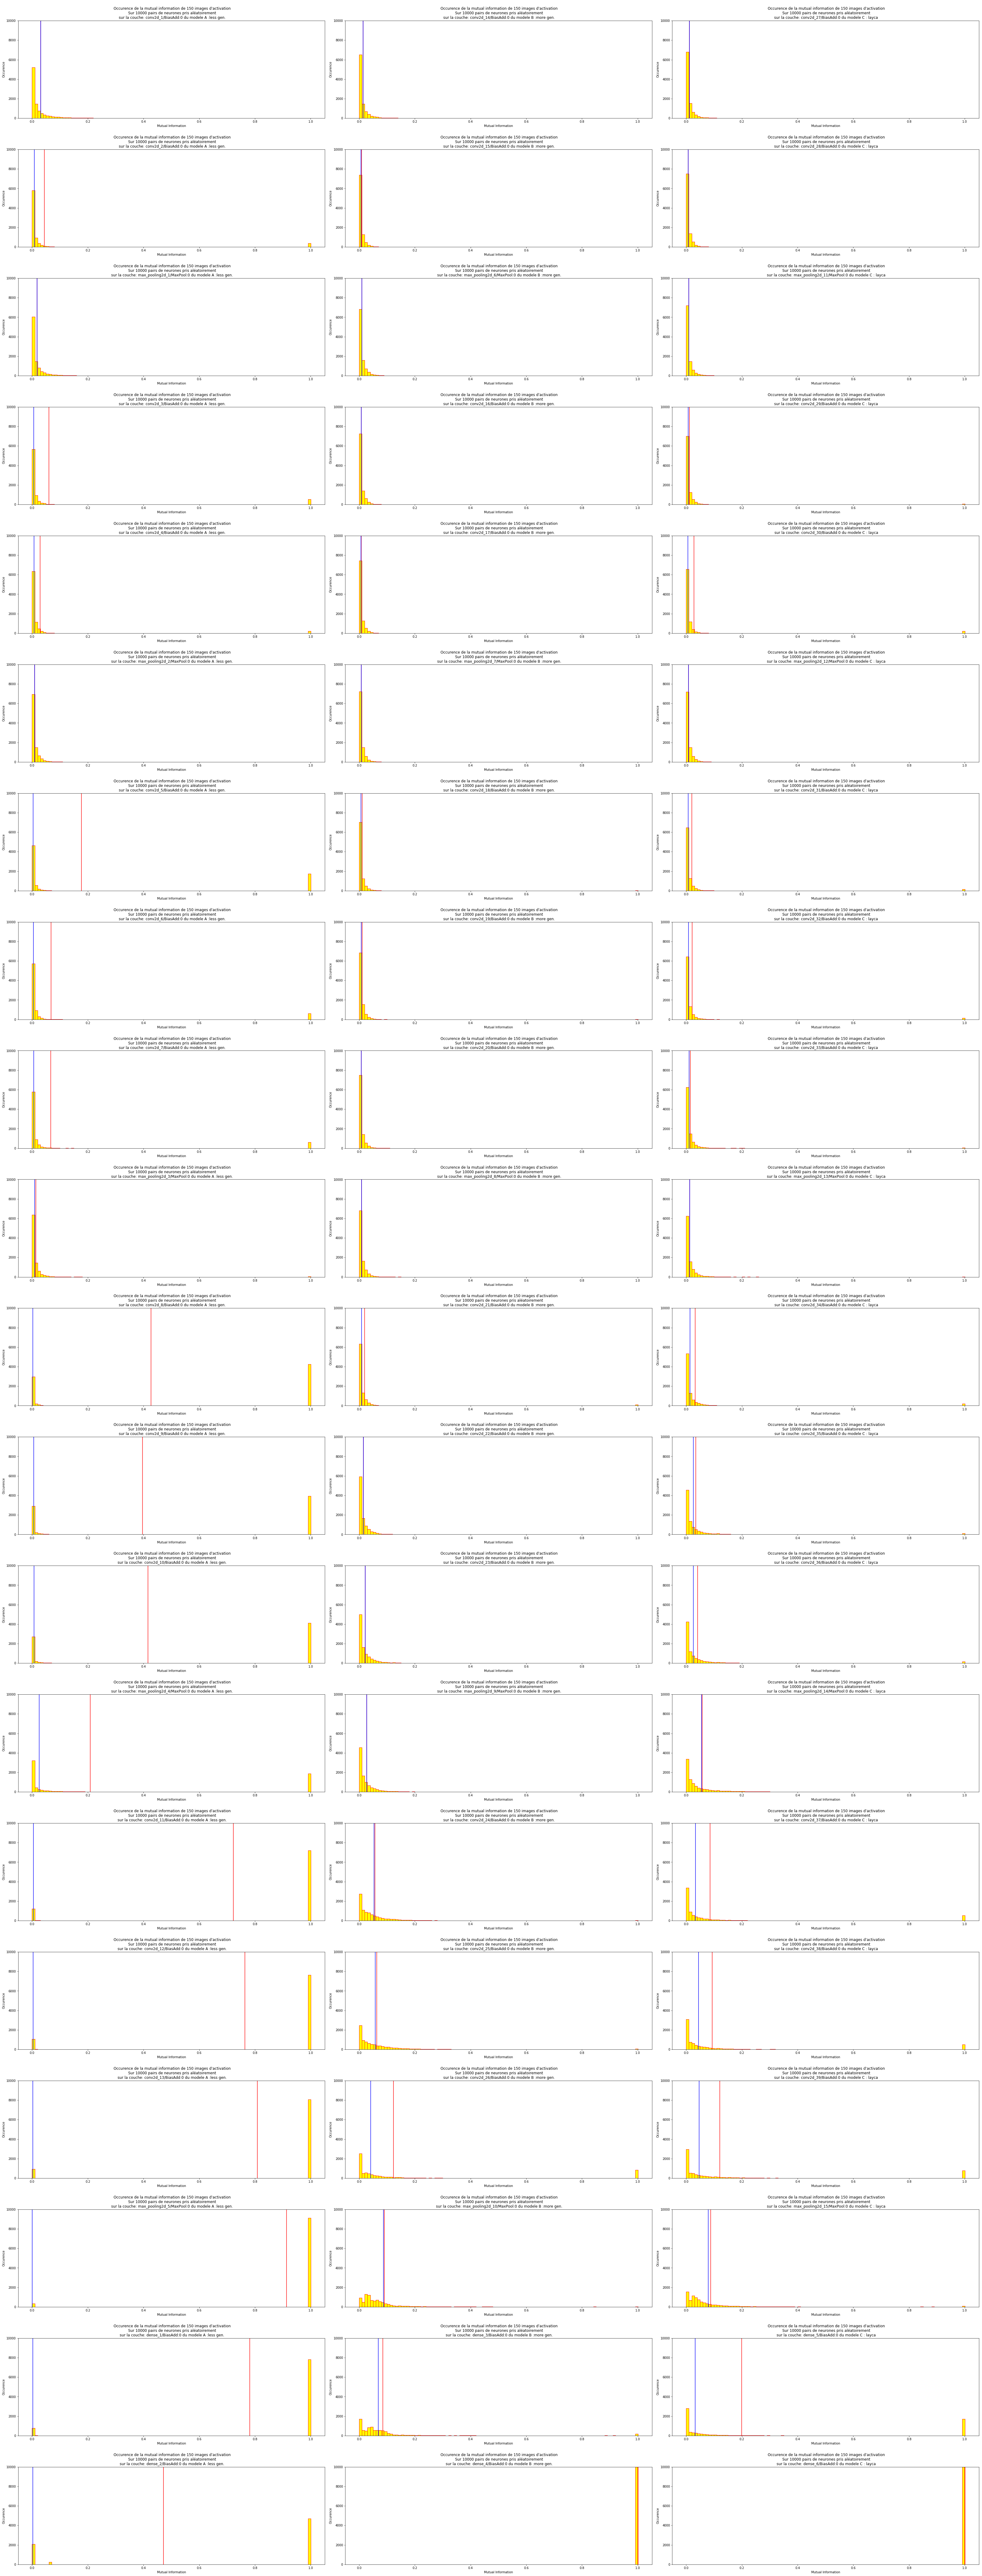

In [14]:
print('number of images used for see the activations : '+str(nombreDImagesDActivation) + '\n')
print('number of pairs of neurons analyzed: '+str(NombrePairs))

fig = plt.figure(figsize=(45, 300))
plt.ylim(top=1000)

# model A sans weights decay a gauche
print('\n Model A :\n')
i = 1
for layer in List_of_Layers_A:
    #nom de la couche
    print('couche :', str(layer))
    #MI
    MutualInfo, MutualInfoWithoutOnes, CountMI1, pathologicCount, pathologicCount_0, pathologicCount_1 = MI(IMA, layer)
    MIMeanA.append(numpy.mean(MutualInfo))
    MI_1MeanA.append(numpy.mean(MutualInfoWithoutOnes))
    PCountA.append(pathologicCount)
    PCountA_0.append(pathologicCount_0)
    PCountA_1.append(pathologicCount_1)
    #plot
    plt.subplot(len(IMA), 3, i)
    plt.hist(MutualInfo, range = (0, 1.001), bins = 100, color = 'yellow',
            edgecolor = 'red')
    plt.xlabel('Mutual Information')
    plt.ylabel('Occurence')
    plt.title('\n Occurence de la mutual information de '+str(nombreDImagesDActivation)+' images d\'activation\n Sur '+str(NombrePairs)+' pairs de neurones pris aléatoirement\n sur la couche: '+ str(layer)+' du modele A :less gen.')
    plt.tight_layout()
    plt.ylim(top=NombrePairs)
    plt.axvline(x=MIMeanA[-1], color='red')
    plt.axvline(x=MI_1MeanA[-1], color='blue')
    print('MI mean: ', str(MIMeanA[-1]))
    print('MI without_1 mean: ', str(MI_1MeanA[-1]))
    if CountMI1 != 0:
        VarPathA.append(pathologicCount/CountMI1)
    else:
        VarPathA.append(0)
    print('pathologic pair Count: ', str(pathologicCount),' on ',str(CountMI1),' MI_1 = ',str(VarPathA[-1]*100),'%')
    print('pathologic pair Count: ', str(pathologicCount),' on ',str(NombrePairs),' pairs = ',str(pathologicCount/NombrePairs*100),'%')
    print('pathologic pair Count: ', str(pathologicCount),'->  pathologic Count 0: ',str(pathologicCount_0),'  pathologic Count 1: ',str(pathologicCount_1))
    print('\n')
    i = i + 3

# model B avec weights decay au centre
print('\n Model B :\n')
i = 2
for layer in List_of_Layers_B:
    #nom de la couche
    print('couche :', str(layer))
    if "dropout" not in str(layer): 
        #MI
        MutualInfo, MutualInfoWithoutOnes, CountMI1, pathologicCount, pathologicCount_0, pathologicCount_1 = MI(IMB, layer)
        MIMeanB.append(numpy.mean(MutualInfo))
        MI_1MeanB.append(numpy.mean(MutualInfoWithoutOnes))
        PCountB.append(pathologicCount)
        PCountB_0.append(pathologicCount_0)
        PCountB_1.append(pathologicCount_1)
        #plot
        plt.subplot(len(IMA), 3, i)
        plt.hist(MutualInfo, range = (0, 1.001), bins = 100, color = 'yellow',
            edgecolor = 'red')
        plt.xlabel('Mutual Information')
        plt.ylabel('Occurence')
        plt.title('\n Occurence de la mutual information de '+str(nombreDImagesDActivation)+' images d\'activation\n Sur '+str(NombrePairs)+' pairs de neurones pris aléatoirement\n sur la couche: '+ str(layer)+' du modele B :more gen.')
        plt.tight_layout()
        plt.ylim(top=NombrePairs)
        plt.axvline(x=MIMeanB[-1], color='red')
        plt.axvline(x=MI_1MeanB[-1], color='blue')
        print('MI mean: ', str(MIMeanB[-1]))
        print('MI without_1 mean: ', str(MI_1MeanB[-1]))
        if CountMI1 != 0:
            VarPathB.append(pathologicCount/CountMI1)
        else:
            VarPathB.append(0)
        print('pathologic pair Count: ', str(pathologicCount),' on ',str(CountMI1),' MI_1 = ',str(VarPathB[-1]*100),'%')
        print('pathologic pair Count: ', str(pathologicCount),' on ',str(NombrePairs),' pairs = ',str(pathologicCount/NombrePairs*100),'%')
        print('pathologic pair Count: ', str(pathologicCount),'->  pathologic Count 0: ',str(pathologicCount_0),'  pathologic Count 1: ',str(pathologicCount_1))
        print('\n')
        i = i + 3
        
# model C sans weights decaylayca mais avec  a droite
print('\n Model C :\n')
i = 3
for layer in List_of_Layers_C:
    #nom de la couche
    print('couche :', str(layer))
    if "dropout" not in str(layer): 
        #MI
        MutualInfo, MutualInfoWithoutOnes, CountMI1, pathologicCount, pathologicCount_0, pathologicCount_1 = MI(IMC, layer)
        MIMeanC.append(numpy.mean(MutualInfo))
        MI_1MeanC.append(numpy.mean(MutualInfoWithoutOnes))
        PCountC.append(pathologicCount)
        PCountC_0.append(pathologicCount_0)
        PCountC_1.append(pathologicCount_1)
        #plot
        plt.subplot(len(IMA), 3, i)
        plt.hist(MutualInfo, range = (0, 1.001), bins = 100, color = 'yellow',
            edgecolor = 'red')
        plt.xlabel('Mutual Information')
        plt.ylabel('Occurence')
        plt.title('\n Occurence de la mutual information de '+str(nombreDImagesDActivation)+' images d\'activation\n Sur '+str(NombrePairs)+' pairs de neurones pris aléatoirement\n sur la couche: '+ str(layer)+' du modele C : layca')
        plt.tight_layout()
        plt.ylim(top=NombrePairs)
        plt.axvline(x=MIMeanC[-1], color='red')
        plt.axvline(x=MI_1MeanC[-1], color='blue')
        print('MI mean: ', str(MIMeanC[-1]))
        print('MI without_1 mean: ', str(MI_1MeanC[-1]))
        if CountMI1 != 0:
            VarPathC.append(pathologicCount/CountMI1)
        else:
            VarPathC.append(0)
        print('pathologic pair Count: ', str(pathologicCount),' on ',str(CountMI1),' MI_1 = ',str(VarPathC[-1]*100),'%')
        print('pathologic pair Count: ', str(pathologicCount),' on ',str(NombrePairs),' pairs = ',str(pathologicCount/NombrePairs*100),'%')
        print('pathologic pair Count: ', str(pathologicCount),'->  pathologic Count 0: ',str(pathologicCount_0),'  pathologic Count 1: ',str(pathologicCount_1))
        print('\n')
        i = i + 3
plt.show()

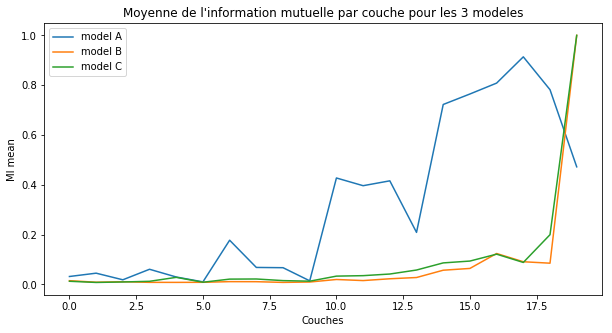

In [15]:
# plot: moyenne de l'information mutuelle
fig = plt.figure(figsize=(10, 5))
plt.plot(MIMeanA)
plt.plot(MIMeanB)
plt.plot(MIMeanC)
plt.legend(['model A', 'model B', 'model C'])
plt.xlabel('Couches')
plt.ylabel('MI mean')
plt.title('Moyenne de l\'information mutuelle par couche pour les 3 modeles')
plt.show()

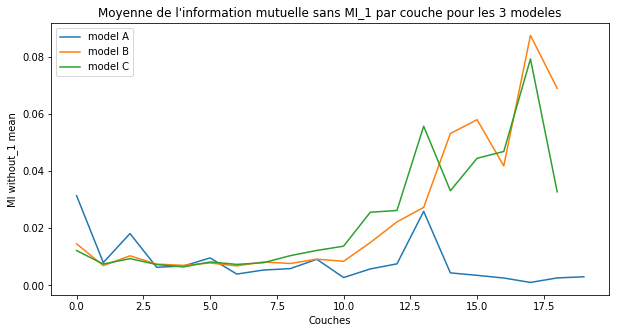

In [16]:
# plot: moyenne de l'information mutuelle sans les valeurs de 1
fig = plt.figure(figsize=(10, 5))
plt.plot(MI_1MeanA)
plt.plot(MI_1MeanB)
plt.plot(MI_1MeanC)
plt.legend(['model A', 'model B', 'model C'])
plt.xlabel('Couches')
plt.ylabel('MI without_1 mean')
plt.title('Moyenne de l\'information mutuelle sans MI_1 par couche pour les 3 modeles')
plt.show()

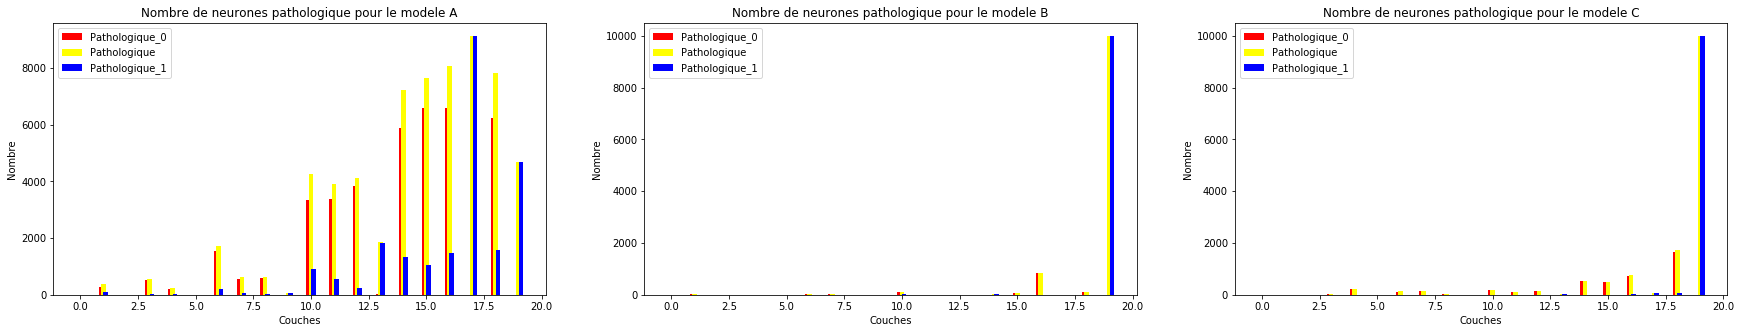

In [19]:
# plot: proportion de pairs de neurones pathologiques
fig = plt.figure(figsize=(30, 5))

plt.subplot(1, 3, 1)
plt.bar(range(len(PCountA_0)),PCountA_0, width=-0.2, align='edge', color='red')
plt.bar(range(len(PCountA)),PCountA, width=0.2, align='center', color='yellow')
plt.bar(range(len(PCountA_1)),PCountA_1, width=0.2, align='edge', color='blue')
plt.legend(['Pathologique_0', 'Pathologique','Pathologique_1'])
plt.xlabel('Couches')
plt.ylabel('Nombre')
plt.title('Nombre de neurones pathologique pour le modele A')

plt.subplot(1, 3, 2)
plt.bar(range(len(PCountB_0)),PCountB_0, width=-0.2, align='edge', color='red')
plt.bar(range(len(PCountB)),PCountB, width=0.2, align='center', color='yellow')
plt.bar(range(len(PCountB_1)),PCountB_1, width=0.2, align='edge', color='blue')
plt.legend(['Pathologique_0', 'Pathologique','Pathologique_1'])
plt.xlabel('Couches')
plt.ylabel('Nombre')
plt.title('Nombre de neurones pathologique pour le modele B')

plt.subplot(1, 3, 3)
plt.bar(range(len(PCountC_0)),PCountC_0, width=-0.2, align='edge', color='red')
plt.bar(range(len(PCountC)),PCountC, width=0.2, align='center', color='yellow')
plt.bar(range(len(PCountC_1)),PCountC_1, width=0.2, align='edge', color='blue')
plt.legend(['Pathologique_0', 'Pathologique','Pathologique_1'])
plt.xlabel('Couches')
plt.ylabel('Nombre')
plt.title('Nombre de neurones pathologique pour le modele C')

plt.show()

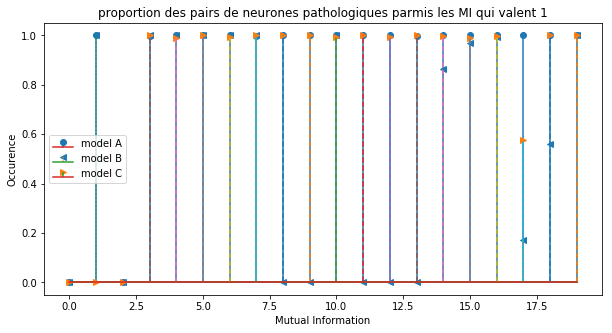

In [22]:
# graphe de shit pour savoir la proportion de neurones pathologiques parmis les pairs de neurones avec une MI = 1 pour les 2 modeles
fig = plt.figure(figsize=(10, 5))
markerlineA, stemlinesA, baselineA = plt.stem(VarPathA)
markerlineB, stemlinesB, baselineB = plt.stem(VarPathB, linefmt=':', markerfmt="<", basefmt='C2-')
markerlineC, stemlinesC, baselineC = plt.stem(VarPathC, linefmt='--', markerfmt=">")
plt.legend(['model A', 'model B', 'model C'])
plt.xlabel('Mutual Information')
plt.ylabel('Occurence')
plt.title('proportion des pairs de neurones pathologiques parmis les MI qui valent 1')
plt.show()